# Laboratory work #4

Import all significant libraries for this project.

In [93]:
# Import TensorFlow & Keras Libraries
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Input, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Layer, MultiHeadAttention, LayerNormalization
from keras.layers import Embedding
from keras.metrics import Mean
from keras.layers import TextVectorization
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras import utils

# Import scikit-lean libraries
from sklearn.model_selection import train_test_split

# Import libraries for text processing
import string
import re

# Import transformers libraries
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Import other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import imageio

## Exercise 1 (GANs)

#### Downloading Dataset
Our dataset is CIFAR-10 (from keras.datasets import cifar10)

### Preprocessing Dataset

In [2]:
# Set constant hyperparameters
batch_size = 128
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 100

In [3]:
# Download data from dataset
(x_train, y_train), (_, _) = cifar10.load_data()

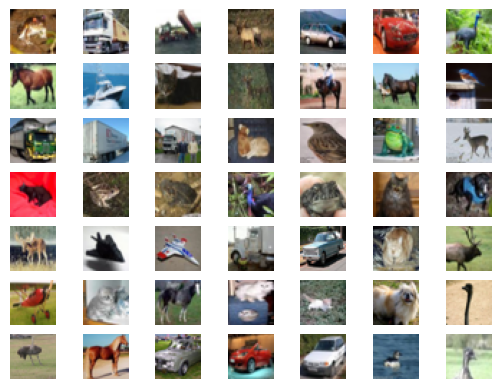

In [4]:
# Plot images from the training dataset
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis("off")
    # plot rqw pixel data
    plt.imshow(x_train[i])
plt.show()

In [5]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [6]:
# Scale the pixel values to [0, 1] range, and a channel dimension to the images,
# and one-hot encode the labels.
X = x_train.astype("float32")
X = (X - 127.5) / 127.5
# X = np.reshape(X, (-1, image_size, image_size, num_channels))
# y = utils.to_categorical(y_train, num_classes)

In [7]:
# Create tf.data.Dataset
# Define dataset
dataset = X
# dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [8]:
# View to shape of Dataset
print(f"Shape of training images: {X.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of training images: (50000, 32, 32, 3)
Shape of training labels: (50000, 1)


In [9]:
def select_real_samples(dataset, n_samples):
    """Function for selecting real samples."""
    # Choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # Retrieve selected images
    X = dataset[ix]
    # Generate "real" class labels
    y = np.ones((n_samples, 1))
    return X, y

In [6]:
def generate_latent_points(latent_dim, n_samples):
    """Function for generating points in latent space as input for the generator"""
    # Generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [11]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """Function for use the generator to generate n fake examples, with class labels"""
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # Predict outputs
    X = g_model.predict(x_input, verbose=0)
    # Create "fake" class labels
    y = np.zeros((n_samples, 1))
    return X, y

In [12]:
# Calculating the number of input channel for the generator and discriminator
generator_nodes = 256 * 4 * 4
print(generator_nodes, num_channels)

4096 3


### Build model

In [13]:
def save_plot(examples, epoch, n=7):
    """Function for creating and saving a plot of generated images;"""
    # Scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # Define subplot
        plt.subplot(n, n, 1 + i)
        # Turn off axis
        plt.axis("off")
        # Plot raw pixel data
        plt.imshow(examples[i])
        # Save plot to file
    filename = "generated_plot_e%03d.png" % (epoch+1)
    plt.savefig(filename)
    plt.close()
    print(">>generated plot saved!!<<")

In [14]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    """Function for evaluating the discriminator, plot generated images, save generator model;"""
    # Prepare real samples
    X_real, y_real = select_real_samples(dataset, n_samples)
    # Evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # Prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # Evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # Summarize discriminator performance
    print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
    # Save plot
    save_plot(x_fake, epoch)
    # Compile model
    g_model.compile()
    # save the generator model title file
    filename = "generator_model_%03d.h5" % (epoch+1)
    g_model.save(filename)

In [15]:
# Define the standalone discriminator
d_inputs = Input(shape=(image_size, image_size, num_channels))
x1 = Conv2D(64, (3, 3), padding="same", activation=LeakyReLU(alpha=0.2))(d_inputs)
x1 = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2))(x1)
x1 = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2))(x1)
x1 = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2))(x1)
x1 = Flatten()(x1)
x1 = Dropout(0.4)(x1)
d_outputs = Dense(1, activation="sigmoid")(x1)
# Build discriminator
discriminator = Model(d_inputs, d_outputs, name="discriminator")
# Define Optimizer
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
# Compile Discriminator
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [16]:
# Create the generator
g_inputs = Input(shape=(latent_dim,))
# We want to generate 128 + num_classes coefficients to reshape into a
# 256x4x4 map.
x2 = Dense(generator_nodes, activation=LeakyReLU(alpha=0.2))(g_inputs)
x2 = Reshape((4, 4, 256))(x2)
# upsample to 8x8
x2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2))(x2)
# upsample to 16x16
x2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2))(x2)
# upsample to 32x32
x2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2))(x2)
# output layer
g_outputs = Conv2D(3, (3, 3), padding="same", activation="tanh")(x2)
# Build generator
generator = Model(g_inputs, g_outputs, name="generator")

In [17]:
def define_gan(g_model, d_model):
    """Function for defining the combined generator and discriminator model, for updating the generator"""
    # Make weights in the discriminator not trainable
    d_model.trainable = False
    # Connect them
    model = Sequential()
    # Add generator
    model.add(g_model)
    # Add discriminator
    model.add(d_model)
    # Compile model
    optimize = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=optimize)
    return model

### Fit model

In [18]:
def train_model(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, batch=128):
    """Function for training the generator and discriminator;"""
    bat_per_epo = int(dataset.shape[0] / batch)
    half_batch = int(batch / 2)
    # Manually enumerate epochs
    for i in range(n_epochs):
    # Enumerate batches over the training set
        for j in range(bat_per_epo):
            # Get randomly selected "real" samples
            X_real, y_real = select_real_samples(dataset, half_batch)
            # Update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # Generate "fake" examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, batch)
            # Create inverted labels for the fake samples
            y_gan = np.ones((batch, 1))
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Summarize loss on this batch
            if (j+1) % 100 == 0:
                print(">%d, %d|%d, d1=%.3f, d2=%.3f g=%.3f" %
                      (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # Evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [19]:
# Define GAN model
gan_model = define_gan(generator, discriminator)

In [ ]:
# Model Fitting
train_model(generator, discriminator, gan_model, dataset,latent_dim, batch=batch_size)

>1, 100|390, d1=0.882, d2=0.261 g=1.773
>1, 200|390, d1=0.703, d2=0.402 g=1.987
>1, 300|390, d1=0.333, d2=0.387 g=1.503
>2, 100|390, d1=0.434, d2=0.380 g=2.027
>2, 200|390, d1=0.536, d2=0.312 g=1.684
>2, 300|390, d1=0.494, d2=0.621 g=1.376
>3, 100|390, d1=0.545, d2=0.499 g=1.129
>3, 200|390, d1=0.852, d2=0.517 g=1.413
>3, 300|390, d1=0.668, d2=0.606 g=1.030
>4, 100|390, d1=0.551, d2=0.624 g=1.260
>4, 200|390, d1=0.608, d2=0.521 g=1.341
>4, 300|390, d1=0.695, d2=0.632 g=1.135
>5, 100|390, d1=0.631, d2=0.573 g=1.119
>5, 200|390, d1=0.735, d2=0.516 g=1.169
>5, 300|390, d1=0.570, d2=0.625 g=0.892
>6, 100|390, d1=0.612, d2=0.625 g=1.009
>6, 200|390, d1=0.721, d2=0.408 g=1.436
>6, 300|390, d1=0.580, d2=0.574 g=1.214
>7, 100|390, d1=0.662, d2=0.575 g=1.200
>7, 200|390, d1=0.569, d2=0.569 g=1.267
>7, 300|390, d1=0.561, d2=0.562 g=1.113
>8, 100|390, d1=0.667, d2=0.509 g=1.530
>8, 200|390, d1=0.627, d2=0.422 g=1.406
>8, 300|390, d1=0.969, d2=0.359 g=1.347
>9, 100|390, d1=0.596, d2=0.446 g=1.397


### Evaluate model

Interpolating between classes with the trained generator

In [16]:
def create_plot(examples, n=7):
    """Function for plotting the generated images;"""
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis("off")
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [17]:
# We first extract the trained generator of GAN from file
trained_gan = load_model("generator_model_040.h5")

In [18]:
# Sample noise for generator
latent_points = generate_latent_points(100, 100)
# Generate images
X = trained_gan.predict(latent_points)
# Scale from [-1,1] to [0,1]
fake_images = (X + 1) / 2.

4/4 [==============================] - 0s 13ms/step


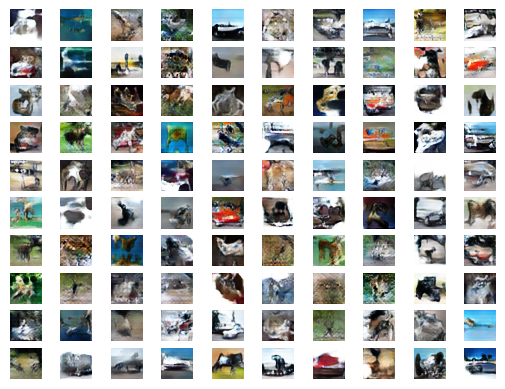

In [19]:
# Plot the result
create_plot(fake_images, 10)

### Conclusion

Model have trained on 49 epochs and this get small result for see contours of objects. But for better result model need more epochs for training.

## Exercise 2 (Machine translation)

#### Downloading Dataset
Our dataset is  (from Manythings.org [Norwegian Bokmal - English](http://www.manythings.org/anki/))

### Preprocessing Dataset

In [63]:
# Load data from file
text_file = pathlib.Path("datasets/nob-eng/norwegian-nob.txt")

In [64]:
# Parsing the data from file
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    # print(line.split("\t"))
    eng, norw, _ = line.split("\t")
    norw = "[start] " + norw + " [end]"
    text_pairs.append((eng, norw))

In [65]:
# View on the English text, and it's translation to Norwegian
for _ in range(5):
    print(text_pairs[np.random.choice(len(text_pairs))])

('I ate dinner while watching TV.', '[start] Jeg spiste middag mens jeg sÃ¥ pÃ¥ TV. [end]')
('Someone has stolen my car.', '[start] Noen har stjÃ¥let bilen min. [end]')
('How much did it cost?', '[start] Hvor mye kostet det? [end]')
("We went without him because he wasn't ready.", '[start] Vi gikk uten ham fordi han ikke var klar. [end]')
('I need someone to protect me.', '[start] Jeg trenger noen som kan beskytte meg. [end]')


In [66]:
# Splitting data to train, validation and test sets
np.random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples: num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

In [67]:
# View on the sets
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

7382 total pairs
5168 training pairs
1107 validation pairs
1107 test pairs


#### Vectorizing the text data

In [68]:
# Set constant
vocab_size = 15000
sequence_length = 20
batch_size = 64

In [69]:
def custom_standardization(input_string):
    """Function for preprocess text with set lowercase in all symbols and strip all text."""
    # Set punctuation symbols for striping our text
    strip_chars = string.punctuation
    strip_chars = strip_chars.replace("[", "")
    strip_chars = strip_chars.replace("]", "")

    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [70]:
# Set Vectorizer for English and Norwegian separately
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length
)
norw_vectorizer = TextVectorization(
    max_tokens=vocab_size, output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

In [71]:
# Parse English and Norwegian text from train set
train_eng_texts = [pair[0] for pair in train_pairs]
train_norw_texts = [pair[1] for pair in train_pairs]

# Train vectorizers
eng_vectorizer.adapt(train_eng_texts)
norw_vectorizer.adapt(train_norw_texts)

#### Making Dataset

In [72]:
def format_dataset(eng, norw):
    """Function for formatting text dataset;"""
    eng = eng_vectorizer(eng)
    norw = norw_vectorizer(norw)
    return ({"encoder_inputs": eng, "decoder_inputs": norw[:, :-1], }, norw[:, 1:])

In [73]:
def make_dataset(pairs, batch_size):
    """Function for making tf.data.Dataset object with text data;"""
    # set English and Norwegian texts
    eng_texts, norw_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    norw_texts = list(norw_texts)
    # define dataset
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, norw_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [74]:
# Define train and validation dataset
train_ds = make_dataset(train_pairs, batch_size)
val_ds = make_dataset(val_pairs, batch_size)

In [75]:
# View sequence shapes
for inputs, targets in train_ds.take(1):
    print(f"inputs['encoder_inputs'].shape: {inputs['encoder_inputs'].shape}")
    print(f"inputs['decoder_inputs'].shape: {inputs['decoder_inputs'].shape}")
    print(f"targets.shape: {targets.shape}")
    print(inputs['encoder_inputs'])
    print(inputs['decoder_inputs'])
    print(targets)

inputs['encoder_inputs'].shape: (64, 20)
inputs['decoder_inputs'].shape: (64, 20)
targets.shape: (64, 20)
tf.Tensor(
[[   2  391    5 ...    0    0    0]
 [1304    8  509 ...    0    0    0]
 [   6 2382   37 ...    0    0    0]
 ...
 [   2  374  175 ...    0    0    0]
 [  45   18    4 ...    0    0    0]
 [ 511  870   20 ...    0    0    0]], shape=(64, 20), dtype=int64)
tf.Tensor(
[[   2    4  224 ...    0    0    0]
 [   2   67  250 ...    0    0    0]
 [   2    7 2312 ...    0    0    0]
 ...
 [   2    4   64 ...    0    0    0]
 [   2   56 3521 ...    0    0    0]
 [   2  528  813 ...    0    0    0]], shape=(64, 20), dtype=int64)
tf.Tensor(
[[   4  224   20 ...    0    0    0]
 [  67  250  666 ...    0    0    0]
 [   7 2312 2094 ...    0    0    0]
 ...
 [   4   64    8 ...    0    0    0]
 [  56 3521    5 ...    0    0    0]
 [ 528  813    5 ...    0    0    0]], shape=(64, 20), dtype=int64)


### Build model

In [76]:
class TransformerEncoder(Layer):
    """"""
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        """"""
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential([
            Dense(dense_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        """"""
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [77]:
class PositionalEmbedding(Layer):
    """"""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """"""
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        """"""
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        """"""
        return tf.math.not_equal(inputs, 0)

In [78]:
def get_causal_attention_mask(inputs):
    """"""
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    return tf.tile(mask, mult)


class TransformerDecoder(Layer):
    """"""
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        """"""
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential([
            Dense(latent_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        """"""
        causal_mask = get_causal_attention_mask(inputs)
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

In [79]:
# Define constant hyperparameters for model
embed_dim = 256
latent_dim = 2048
num_heads = 8

In [80]:
# Build encoder model
encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = Model(encoder_inputs, encoder_outputs)

In [81]:
# Build decoder model
decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)
decoder = Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [82]:
# Build Transformer model
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

### Fit model

In [83]:
# Set number of epochs for training
num_epochs = 30

In [84]:
# View summary of model
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_4 (Positi  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_2 (Transfo  (None, None, 256)   3155456     ['positional_embedding_

In [85]:
# Compile model
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [86]:
# Fit our model
transformer.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

InvalidArgumentError: Graph execution error:

Detected at node 'transformer/transformer_encoder_2/multi_head_attention_6/softmax/add' defined at (most recent call last):
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Who\AppData\Local\Temp\ipykernel_9264\2799841133.py", line 2, in <module>
      transformer.fit(train_ds, epochs=num_epochs, validation_data=val_ds)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Who\AppData\Local\Temp\ipykernel_9264\3148326736.py", line 25, in call
      attention_output = self.attention(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 596, in call
      attention_output, attention_scores = self._compute_attention(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 527, in _compute_attention
      attention_scores = self._masked_softmax(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 493, in _masked_softmax
      return self._softmax(attention_scores, attention_mask)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\activation\softmax.py", line 95, in call
      inputs += adder
Node: 'transformer/transformer_encoder_2/multi_head_attention_6/softmax/add'
Detected at node 'transformer/transformer_encoder_2/multi_head_attention_6/softmax/add' defined at (most recent call last):
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Who\AppData\Local\Temp\ipykernel_9264\2799841133.py", line 2, in <module>
      transformer.fit(train_ds, epochs=num_epochs, validation_data=val_ds)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Who\AppData\Local\Temp\ipykernel_9264\3148326736.py", line 25, in call
      attention_output = self.attention(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 596, in call
      attention_output, attention_scores = self._compute_attention(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 527, in _compute_attention
      attention_scores = self._masked_softmax(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 493, in _masked_softmax
      return self._softmax(attention_scores, attention_mask)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\layers\activation\softmax.py", line 95, in call
      inputs += adder
Node: 'transformer/transformer_encoder_2/multi_head_attention_6/softmax/add'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  required broadcastable shapes
	 [[{{node transformer/transformer_encoder_2/multi_head_attention_6/softmax/add}}]]
	 [[broadcast_weights_1/assert_broadcastable/is_valid_shape/else/_1/broadcast_weights_1/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/then/_53/broadcast_weights_1/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/has_invalid_dims/concat/_92]]
  (1) INVALID_ARGUMENT:  required broadcastable shapes
	 [[{{node transformer/transformer_encoder_2/multi_head_attention_6/softmax/add}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_18095]

### Evaluate model

In [ ]:
# Set constant for decoding test sentences
norw_vocab = norw_vectorizer.get_vocabulary()
norw_index_lookup = dict(zip(range(len(norw_vocab)), norw_vocab))
max_decoded_sentence_length = 20

In [ ]:
def decode_sequence(input_sentence):
    """"""
    tokenized_input_sentence = eng_vectorizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = norw_vectorizer([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = norw_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break

    return decoded_sentence

In [ ]:
# Decoding test sentences
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = np.random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)

### Conclusion

Model showed good results and get **60% accuracy** on the validation set.
Model results can see in this [google_colab_file](https://colab.research.google.com/drive/1JZGRgoiO0Vlf6GUqFA_gdtBXdU-bdt52?usp=sharing)

## Exercise 3 (Transformers)

#### Downloading Dataset
Our dataset is  (from [kaggle]())

### Preprocessing Dataset

In [88]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

D:\.main\.code\data_analysis_labs\venv\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Who\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_22']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [89]:
txt_1 = "Football is the most exciting and popular game in the world"

In [90]:
classifier(txt_1)

[{'label': 'POSITIVE', 'score': 0.9998573064804077}]

In [91]:
txt_2 = "The weather is unpredictable around here"

In [92]:
classifier(txt_2)

[{'label': 'POSITIVE', 'score': 0.6950808763504028}]

In [95]:
# AutoTokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_42']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
inputs = tokenizer([txt_1, txt_2])

In [97]:
inputs

{'input_ids': [[101, 2374, 2003, 1996, 2087, 10990, 1998, 2759, 2208, 1999, 1996, 2088, 102], [101, 1996, 4633, 2003, 21446, 2105, 2182, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [98]:
inputs_with_padding = tokenizer([txt_1, txt_2], padding=True, truncation=True,
                                max_length=256, return_tensors="tf")

In [99]:
inputs_with_padding

{'input_ids': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[  101,  2374,  2003,  1996,  2087, 10990,  1998,  2759,  2208,
         1999,  1996,  2088,   102],
       [  101,  1996,  4633,  2003, 21446,  2105,  2182,   102,     0,
            0,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])>}

In [100]:
outputs = model(inputs_with_padding)

In [101]:
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-4.2494793 ,  4.605344  ],
       [-0.33055457,  0.49344188]], dtype=float32)>, hidden_states=None, attentions=None)

In [102]:
predictions = tf.nn.softmax(outputs[0], axis=-1)

In [103]:
predictions

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.4267149e-04, 9.9985731e-01],
       [3.0491599e-01, 6.9508398e-01]], dtype=float32)>

### Build model

### Fit model

### Evaluate model

### Conclusion